In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Exploring
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE

# Modeling
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor


# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import math 
import wrangle_functions
import env
import acquire
import prepare

In [2]:
############################################################################### ACQUIRE

In [3]:
# use zillow;
# from acquire.py

def new_zillow_data():
    df = pd.read_sql('''SELECT *
    FROM properties_2017
    LEFT OUTER JOIN airconditioningtype 
    USING(airconditioningtypeid) 
    LEFT OUTER JOIN architecturalstyletype
    USING(architecturalstyletypeid) 
    LEFT OUTER JOIN buildingclasstype 
    USING(buildingclasstypeid) 
    LEFT OUTER JOIN heatingorsystemtype
    USING(heatingorsystemtypeid) 
    LEFT OUTER JOIN predictions_2017
    ON predictions_2017.id = properties_2017.id
    INNER JOIN (
    SELECT id, MAX(transactiondate) as last_trans_date 
    FROM predictions_2017
    GROUP BY id
    ) predictions ON predictions.id = properties_2017.id AND predictions_2017.transactiondate = predictions.last_trans_date
    LEFT OUTER JOIN propertylandusetype
    USING(propertylandusetypeid)
      LEFT OUTER JOIN storytype
    USING(storytypeid)
    LEFT OUTER JOIN typeconstructiontype
    USING(typeconstructiontypeid)
    JOIN unique_properties
      ON unique_properties.parcelid = properties_2017.parcelid
    WHERE latitude IS NOT NULL and longitude IS NOT NULL;''', acquire.get_connection('zillow'))
    return df

In [4]:
df = new_zillow_data()

In [5]:
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,parcelid,basementsqft,...,id,parcelid,logerror,transactiondate,id,last_trans_date,propertylandusedesc,storydesc,typeconstructiondesc,parcelid
0,NaN,NaN,269.00,NaN,NaN,NaN,NaN,0,10754147,NaN,...,0,14297519,0.03,2017-01-01,0,2017-01-01,Planned Unit Development,None,None,10754147
1,NaN,NaN,261.00,NaN,NaN,NaN,NaN,1,10759547,NaN,...,1,17052889,0.06,2017-01-01,1,2017-01-01,Single Family Residential,None,None,10759547
2,NaN,NaN,47.00,NaN,5.00,NaN,NaN,2,10843547,NaN,...,2,14186244,0.01,2017-01-01,2,2017-01-01,Store/Office (Mixed Use),None,None,10843547
3,NaN,NaN,47.00,NaN,3.00,NaN,NaN,3,10859147,NaN,...,3,12177905,-0.10,2017-01-01,3,2017-01-01,Store/Office (Mixed Use),None,None,10859147
4,NaN,NaN,31.00,NaN,4.00,NaN,NaN,4,10879947,NaN,...,4,10887214,0.01,2017-01-01,4,2017-01-01,Commercial/Office/Residential Mixed Used,None,None,10879947


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77614 entries, 0 to 77613
Data columns (total 73 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        166 non-null    float64
 1   storytypeid                   45 non-null     float64
 2   propertylandusetypeid         77614 non-null  float64
 3   heatingorsystemtypeid         48475 non-null  float64
 4   buildingclasstypeid           383 non-null    float64
 5   architecturalstyletypeid      151 non-null    float64
 6   airconditioningtypeid         21457 non-null  float64
 7   id                            77614 non-null  int64  
 8   parcelid                      77614 non-null  int64  
 9   basementsqft                  45 non-null     float64
 10  bathroomcnt                   77614 non-null  float64
 11  bedroomcnt                    77614 non-null  float64
 12  buildingqualitytypeid         50322 non-null  float64
 13  c

In [7]:
df.describe()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,parcelid,basementsqft,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id,parcelid,logerror,id,parcelid
count,166.00,45.00,"77,614.00","48,475.00",383.00,151.00,"21,457.00","77,614.00","77,614.00",45.00,...,"77,614.00","76,003.00","77,103.00","1,505.00","75,519.00","77,614.00","77,614.00","77,614.00","77,614.00","77,614.00"
mean,5.99,7.00,259.94,4.04,3.78,7.43,1.93,"38,806.50","13,379,428.47",593.13,...,"2,016.00","265,047.58","5,371.52",13.91,"60,489,761,355,119.06","38,806.50","13,007,807.98",0.02,"38,806.50","13,379,428.47"
std,0.16,0.00,16.97,3.23,0.46,2.63,3.13,"22,405.38","8,351,447.64",460.92,...,0.07,"528,079.16","10,407.55",1.54,"210,075,285,376.01","22,405.38","3,518,694.35",0.17,"22,405.38","8,351,447.64"
min,4.00,7.00,31.00,1.00,1.00,2.00,1.00,0.00,"10,711,745.00",63.00,...,"2,003.00",4.00,2.54,6.00,"60,371,011,101,000.00",0.00,"10,711,855.00",-4.66,0.00,"10,711,745.00"
25%,6.00,7.00,261.00,2.00,4.00,7.00,1.00,"19,403.25","11,585,723.50",220.00,...,"2,016.00","78,406.50","2,449.60",14.00,"60,373,106,017,007.00","19,403.25","11,538,214.00",-0.02,"19,403.25","11,585,723.50"
50%,6.00,7.00,261.00,2.00,4.00,7.00,1.00,"38,806.50","12,532,247.00",540.00,...,"2,016.00","175,342.00","4,006.66",14.00,"60,375,718,002,010.00","38,806.50","12,530,061.50",0.01,"38,806.50","12,532,247.00"
75%,6.00,7.00,261.00,7.00,4.00,7.00,1.00,"58,209.75","14,115,087.00",732.00,...,"2,016.00","324,677.00","6,198.60",15.00,"60,590,423,262,017.00","58,209.75","14,211,001.25",0.04,"58,209.75","14,115,087.00"
max,6.00,7.00,275.00,24.00,5.00,21.00,13.00,"77,613.00","169,601,949.00","2,443.00",...,"2,016.00","94,011,079.00","1,824,154.85",15.00,"61,110,091,003,005.00","77,613.00","167,689,317.00",5.26,"77,613.00","169,601,949.00"


In [8]:
df.shape

(77614, 73)

In [9]:
df.dtypes

typeconstructiontypeid    float64
storytypeid               float64
propertylandusetypeid     float64
heatingorsystemtypeid     float64
buildingclasstypeid       float64
                           ...   
last_trans_date            object
propertylandusedesc        object
storydesc                  object
typeconstructiondesc       object
parcelid                    int64
Length: 73, dtype: object

In [10]:
# create list of single unit propertylandusedesc
single_prop_types = ['Single Family Residential', 'Condominium', 'Mobile Home',
                     'Manufactured, Modular, Prefabricated Homes', 'Townhouse']
# filter for most-likely single unit properties
df = df[df.propertylandusedesc.isin(single_prop_types)]
df = df[(df.bedroomcnt > 0) & (df.bedroomcnt <= 10)]
df = df[(df.bathroomcnt > 0) & (df.bathroomcnt <= 10)]

In [11]:
df.shape

(68041, 73)

In [12]:
wrangle_functions.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
typeconstructiontypeid,67875,99.76
storytypeid,67997,99.94
propertylandusetypeid,0,0.00
heatingorsystemtypeid,22889,33.64
buildingclasstypeid,68041,100.00
...,...,...
last_trans_date,0,0.00
propertylandusedesc,0,0.00
storydesc,67997,99.94
typeconstructiondesc,67875,99.76


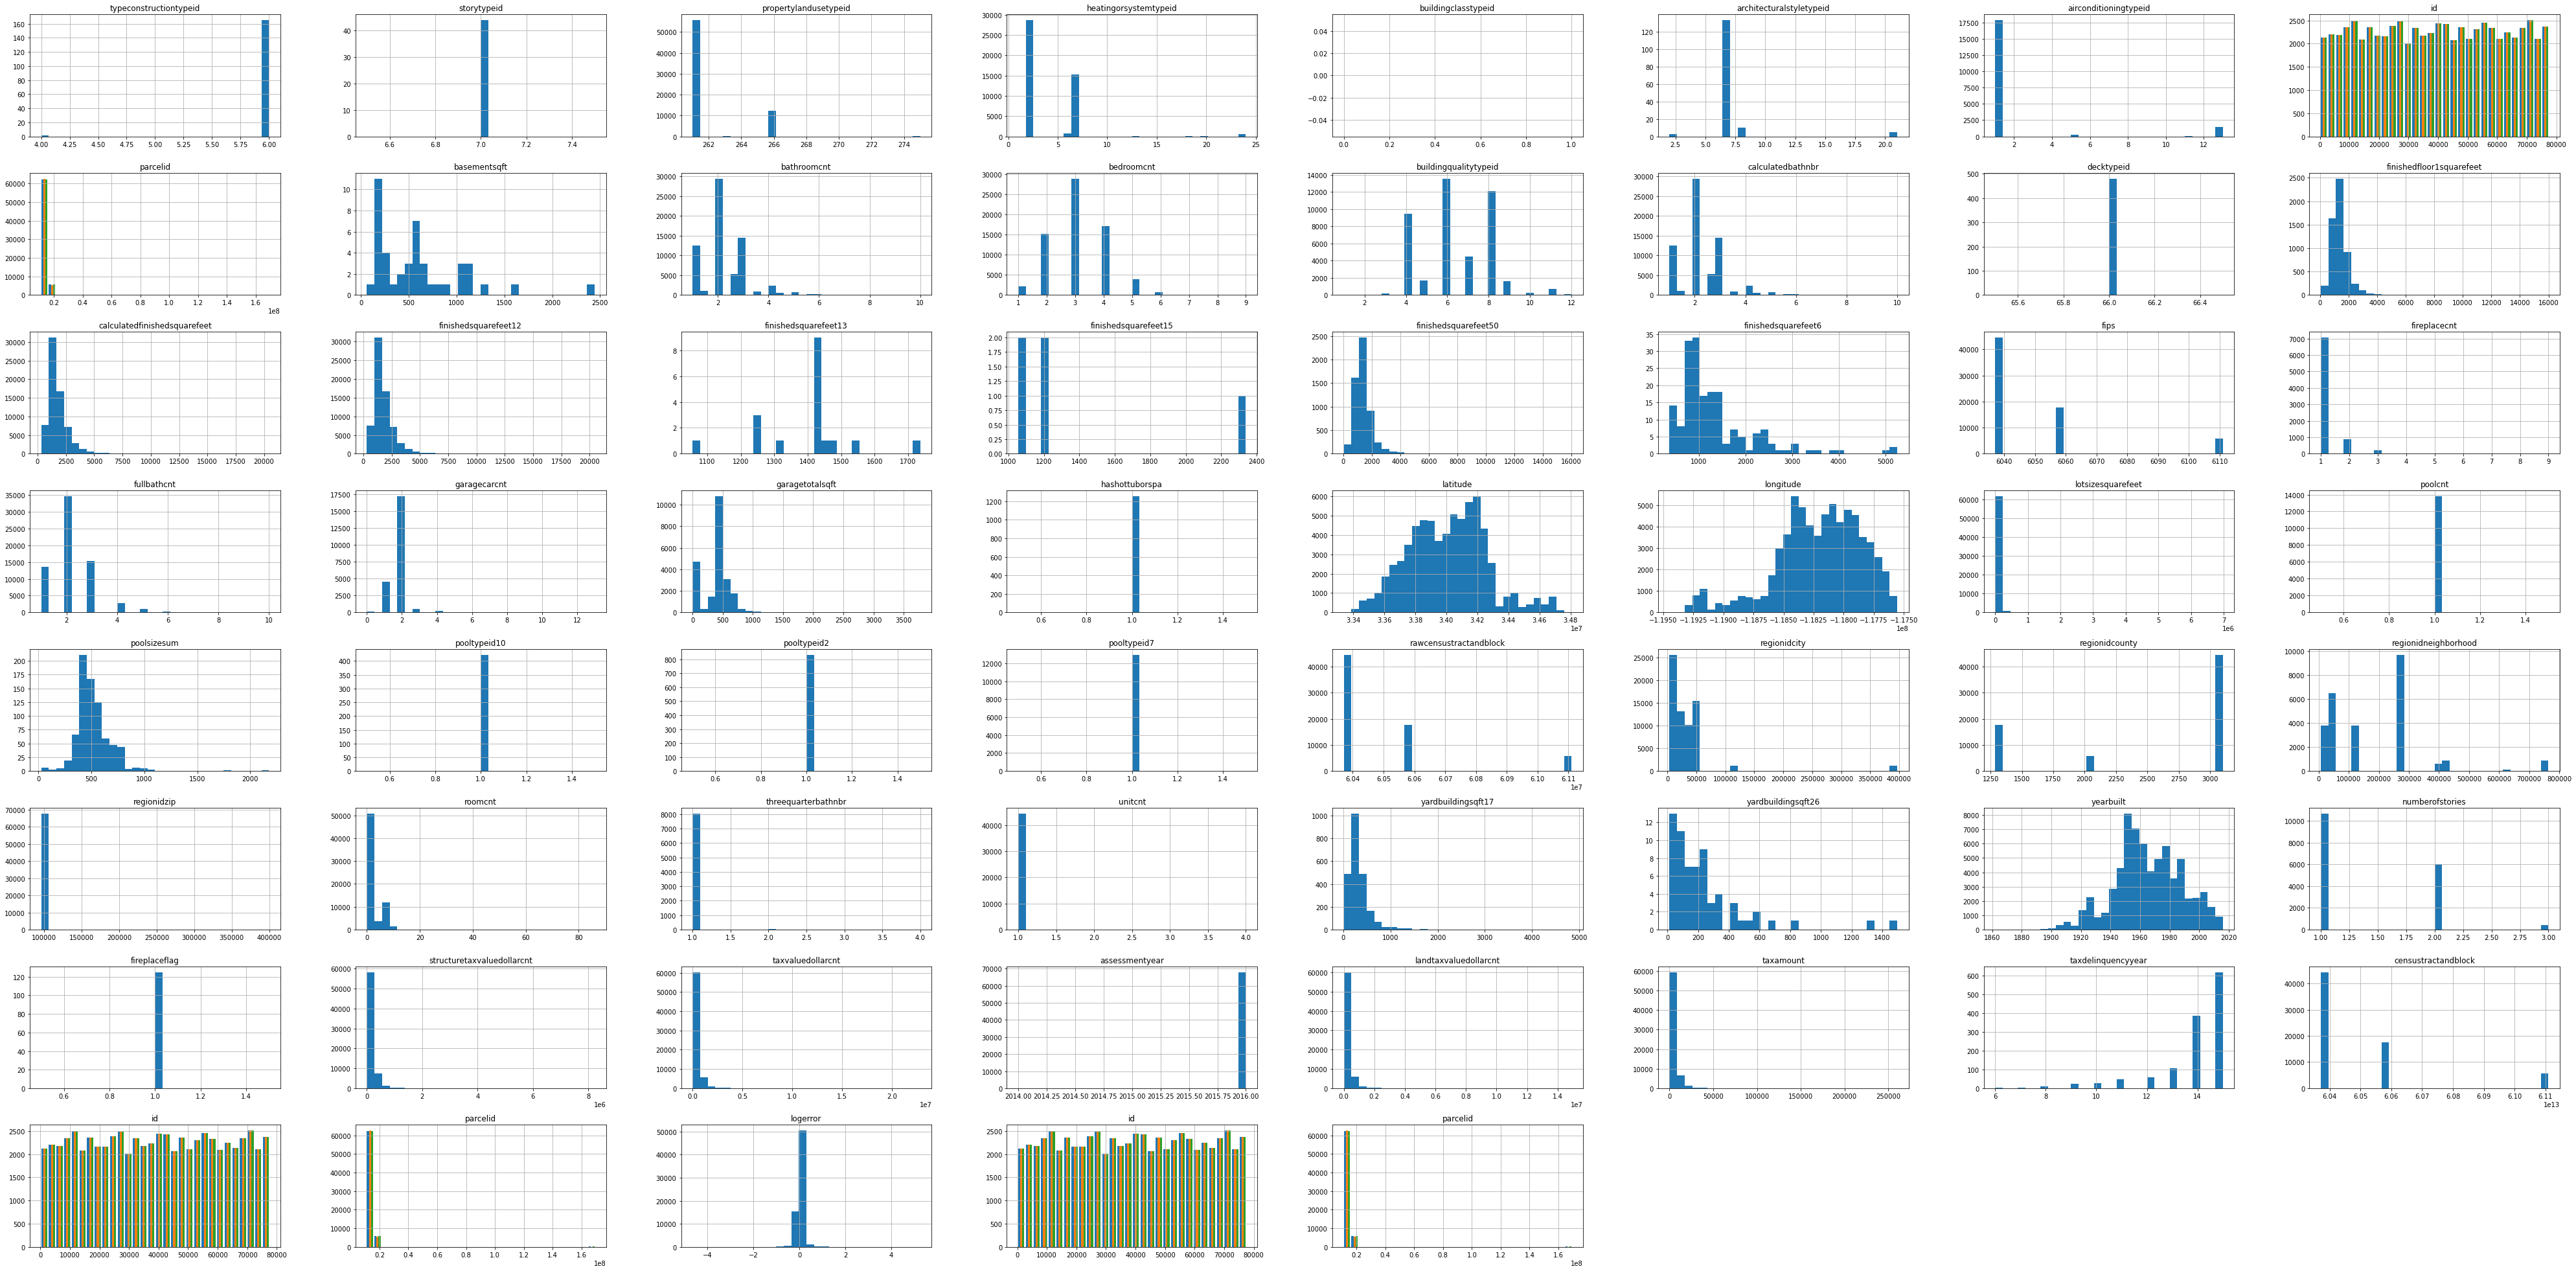

In [13]:
# plot histograms for all variables
df.hist(figsize=(70, 35), bins=30)
plt.show()

********************************************************************* Acquire Takeaways

In [14]:
# how many null values are in each columns 
wrangle_functions.nulls_by_col(df)

,num_rows_missing,percent_rows_missing
typeconstructiontypeid,67875,99.76
storytypeid,67997,99.94
propertylandusetypeid,0,0.00
heatingorsystemtypeid,22889,33.64
buildingclasstypeid,68041,100.00
...,...,...
last_trans_date,0,0.00
propertylandusedesc,0,0.00
storydesc,67997,99.94
typeconstructiondesc,67875,99.76


In [15]:
def drop_cols_null(df, max_missing_rows_pct=0.25):
    '''
    Takes in a DataFrame and a maximum percent for missing values and
    returns the passed DataFrame after removing any colums missing the
    defined max percent or more worth of rows
    '''
    
    # set threshold for axis=1 and drop cols
    thresh_col = math.ceil(df.shape[0] * (1 - max_missing_rows_pct))
    df = df.dropna(axis=1, thresh=thresh_col)

    return df

In [16]:
# I want to drop any column with more than 25% of the values missing
df = drop_cols_null(df)

In [17]:
# the above function removed 39 columns
df.shape

(68041, 34)

In [18]:
df.head()

,propertylandusetypeid,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,taxamount,censustractandblock,id,parcelid,logerror,transactiondate,id,last_trans_date,propertylandusedesc,parcelid
20,261.00,20,11324547,2.00,4.00,2.00,"3,633.00","3,633.00","6,037.00",2.00,...,"6,941.39",NaN,20,12325145,0.04,2017-01-02,20,2017-01-02,Single Family Residential,11324547
30,266.00,30,11524947,2.00,2.00,2.00,"1,090.00","1,090.00","6,037.00",2.00,...,"6,165.36",NaN,30,12713253,0.02,2017-01-02,30,2017-01-02,Condominium,11524947
31,261.00,31,11544747,4.00,3.00,4.00,"1,620.00","1,620.00","6,037.00",4.00,...,"10,244.94",NaN,31,14338242,-0.02,2017-01-02,31,2017-01-02,Single Family Residential,11544747
33,261.00,33,11585547,2.00,3.00,2.00,"2,077.00","2,077.00","6,037.00",2.00,...,"7,924.68",NaN,33,12155445,-0.04,2017-01-02,33,2017-01-02,Single Family Residential,11585547
37,266.00,37,11617547,3.00,2.00,3.00,"2,735.00","2,735.00","6,037.00",3.00,...,"34,982.17",NaN,37,11682477,0.03,2017-01-02,37,2017-01-02,Condominium,11617547


In [19]:
df.columns

Index(['propertylandusetypeid', 'id', 'parcelid', 'bathroomcnt', 'bedroomcnt',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'id', 'parcelid', 'logerror',
       'transactiondate', 'id', 'last_trans_date', 'propertylandusedesc',
       'parcelid'],
      dtype='object')

In [20]:
df =df.drop(columns= ['propertylandusetypeid', 'id', 
       'calculatedbathnbr','rawcensustractandblock',
        'propertycountylandusecode','regionidcounty','finishedsquarefeet12',
       'regionidzip', 'yearbuilt','id','censustractandblock','last_trans_date',
       'transactiondate', 'id','roomcnt','fullbathcnt','assessmentyear','propertylandusedesc'])


In [21]:
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'parcelid', 'logerror',
       'parcelid'],
      dtype='object')

In [22]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,parcelid,logerror,parcelid
20,11324547,2.00,4.00,"3,633.00","6,037.00","34,560,018.00","-118,169,806.00","9,826.00","40,227.00","222,321.00","296,425.00","74,104.00","6,941.39",12325145,0.04,11324547
30,11524947,2.00,2.00,"1,090.00","6,037.00","33,974,100.00","-118,423,000.00","40,247.00","12,447.00","232,897.00","357,568.00","124,671.00","6,165.36",12713253,0.02,11524947
31,11544747,4.00,3.00,"1,620.00","6,037.00","33,996,200.00","-118,438,000.00",NaN,"12,447.00","339,532.00","847,770.00","508,238.00","10,244.94",14338242,-0.02,11544747
33,11585547,2.00,3.00,"2,077.00","6,037.00","34,012,977.00","-118,479,243.00","6,490.00","26,964.00","210,192.00","646,760.00","436,568.00","7,924.68",12155445,-0.04,11585547
37,11617547,3.00,2.00,"2,735.00","6,037.00","34,059,700.00","-118,439,000.00",NaN,"12,447.00","757,582.00","2,922,104.00","2,164,522.00","34,982.17",11682477,0.03,11617547


In [23]:
#check to see if they have the same values
df.parcelid.nunique()

parcelid    68041
parcelid    67880
parcelid    68041
dtype: int64

In [24]:
# here I am dropping the duplicate parcelid column
df = df.iloc[:,~df.columns.duplicated()]

In [25]:
# checking to make sure that happened
df.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcity',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror'],
      dtype='object')

In [26]:
#rename columns we might keep for better understanding
#df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)
df = df.rename(columns={'bathroomcnt':'bathrooms','bedroomcnt': 'bedrooms','calculatedfinishedsquarefeet':
         'area','fips':'zipcode','lotsizesquarefeet': 'lot_area','taxvaluedollarcnt':'tax_value'})

In [27]:
df.shape

(68041, 14)

In [28]:
df = wrangle_functions.handle_missing_values(df)

In [29]:
df.shape

(68041, 14)

In [30]:
# replace nulls with median values for lot_area
df.lot_area.fillna(7313, inplace = True)

In [31]:
# check for nulls values
df.isna().sum()

parcelid                         0
bathrooms                        0
bedrooms                         0
area                             5
zipcode                          0
latitude                         0
longitude                        0
lot_area                         0
regionidcity                  1237
structuretaxvaluedollarcnt      72
tax_value                        4
landtaxvaluedollarcnt            4
taxamount                       81
logerror                         0
dtype: int64

In [32]:
# drop columns with nulls for yearbuilt, taxvaluedollarcnt and taxamount to avoid target leakage
df = df.dropna()

In [33]:
# let's check dtypes again now that I have the columns I want
df.dtypes

parcelid                        int64
bathrooms                     float64
bedrooms                      float64
area                          float64
zipcode                       float64
latitude                      float64
longitude                     float64
lot_area                      float64
regionidcity                  float64
structuretaxvaluedollarcnt    float64
tax_value                     float64
landtaxvaluedollarcnt         float64
taxamount                     float64
logerror                      float64
dtype: object

In [34]:
# correcting dtype
#df.propertylandusetypeid.astype(object)

In [35]:
# correcting dtype
df.zipcode.astype(object)

20                  6,037.00
30                  6,037.00
31                  6,037.00
33                  6,037.00
37                  6,037.00
                ...         
77609               6,037.00
77610               6,037.00
77611               6,037.00
77612               6,037.00
77613               6,037.00
Name: zipcode, Length: 66703, dtype: object

In [36]:
# correcting dtype
#df.regionidcounty.astype(object)

In [37]:
# I looked up the the average home size is 2,300 sqft so I will make that the cutoff 
# between a large and small home
# here I want to divide the homes and insert into a column those that are more than 2,300 sqft
df['large_home'] =(df['area']> 2300).astype(int)

In [38]:
df.large_home.value_counts()

0    54253
1    12450
Name: large_home, dtype: int64

In [39]:
# check and change dtypes for each column
df.dtypes

parcelid                        int64
bathrooms                     float64
bedrooms                      float64
area                          float64
zipcode                       float64
latitude                      float64
longitude                     float64
lot_area                      float64
regionidcity                  float64
structuretaxvaluedollarcnt    float64
tax_value                     float64
landtaxvaluedollarcnt         float64
taxamount                     float64
logerror                      float64
large_home                      int64
dtype: object

In [40]:
df.shape

(66703, 15)

In [41]:
#drop propertylanusetypeid, parcelid, propertylandusedesc, landtaxvaluedollarcnt,structuretaxvaluedollarcnt
df.drop(columns = ['parcelid','landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt'])

,bathrooms,bedrooms,area,zipcode,latitude,longitude,lot_area,regionidcity,tax_value,taxamount,logerror,large_home
20,2.00,4.00,"3,633.00","6,037.00","34,560,018.00","-118,169,806.00","9,826.00","40,227.00","296,425.00","6,941.39",0.04,1
30,2.00,2.00,"1,090.00","6,037.00","33,974,100.00","-118,423,000.00","40,247.00","12,447.00","357,568.00","6,165.36",0.02,0
31,4.00,3.00,"1,620.00","6,037.00","33,996,200.00","-118,438,000.00","7,313.00","12,447.00","847,770.00","10,244.94",-0.02,0
33,2.00,3.00,"2,077.00","6,037.00","34,012,977.00","-118,479,243.00","6,490.00","26,964.00","646,760.00","7,924.68",-0.04,0
37,3.00,2.00,"2,735.00","6,037.00","34,059,700.00","-118,439,000.00","7,313.00","12,447.00","2,922,104.00","34,982.17",0.03,1
...,...,...,...,...,...,...,...,...,...,...,...,...
77609,3.00,4.00,"1,921.00","6,037.00","34,572,256.00","-118,024,872.00","6,763.00","40,227.00","162,019.00","2,860.33",0.02,0
77610,3.00,4.00,"1,780.00","6,037.00","34,571,498.00","-118,039,412.00","6,822.00","40,227.00","125,923.00","2,394.26",0.01,0
77611,2.00,3.00,"1,549.00","6,037.00","34,575,327.00","-118,054,267.00","6,987.00","40,227.00","198,988.00","3,331.81",0.04,0
77612,3.00,3.00,"1,339.00","6,037.00","34,572,200.00","-118,053,000.00","271,458.00","40,227.00","148,600.00","2,510.53",0.01,0


In [42]:
# remove duplicate entries
# sorting by first name
df.sort_values("parcelid", inplace=True)
 
# dropping duplicate values
df.drop_duplicates(keep=False,inplace=True)

In [43]:
# this shows me there were no existing duplicates
df.shape

(66703, 15)

In [44]:
# Columns to look for extreme outliers, taxx_value and area
df = df[df.tax_value < 5_000_000]
df = df[df.area < 8000]

In [45]:
df.shape

(66515, 15)

In [46]:
# now I want to make a df with no outliers in any column for 
# comparison in exploration
def outlier_function(df,cols, k):
#function to detect and handle oulier using IQR rule
    df_out = pd.DataFrame()
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr
        new_data = df[(df[col] > upper_bound) | (df[col] < lower_bound)]
        missing_index = new_data.index.difference(df_out.index)
        df_out = df_out.append(new_data.loc[missing_index, : ])
    return df_out

In [47]:
df_out = outlier_function(df,df.columns,3)

In [48]:
df_out.head()

,parcelid,bathrooms,bedrooms,area,zipcode,latitude,longitude,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,logerror,large_home
726,162960663,3.00,4.00,"2,442.00","6,111.00","34,177,520.00","-119,216,381.00","5,296.00","47,198.00","225,512.00","375,849.00","150,337.00","4,353.76",-0.01,1
30745,162960780,3.00,4.00,"2,168.00","6,111.00","34,288,945.00","-118,728,102.00","9,347.00","27,110.00","281,046.00","468,407.00","187,361.00","5,582.28",0.27,0
44877,162960342,1.00,2.00,"1,368.00","6,111.00","34,444,517.00","-119,284,026.00","11,758.00","13,091.00","95,180.00","314,843.00","219,663.00","4,001.86",0.01,0
60830,162960862,3.00,4.00,"2,648.00","6,111.00","34,140,333.00","-118,843,128.00","29,251.00","41,673.00","452,676.00","905,352.00","452,676.00","10,244.04",0.08,1
73254,162960432,4.00,5.00,"3,317.00","6,111.00","34,285,818.00","-119,195,481.00","7,028.00","34,543.00","376,624.00","753,248.00","376,624.00","7,865.86",0.10,1


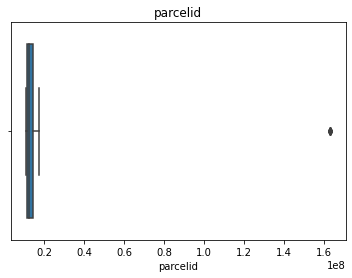

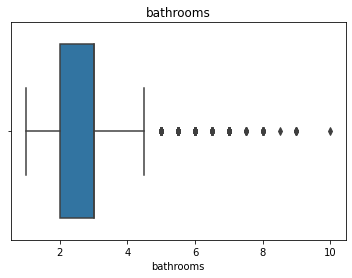

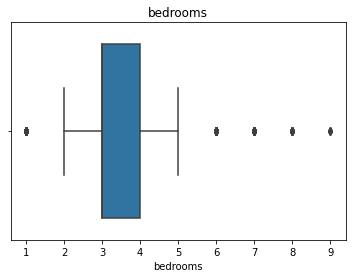

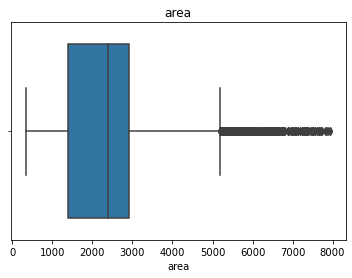

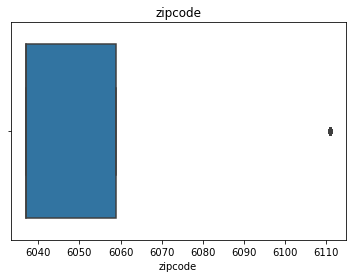

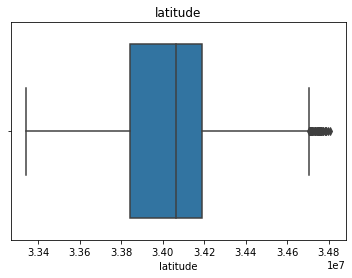

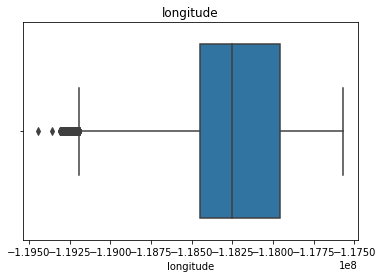

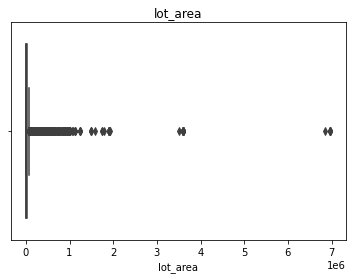

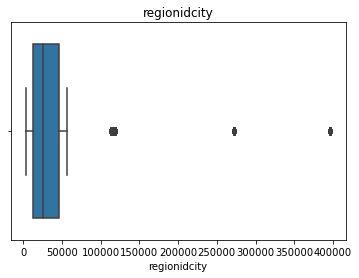

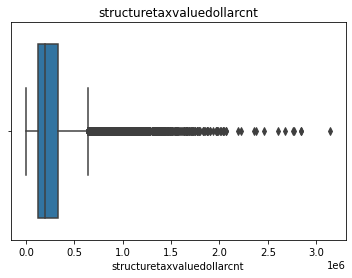

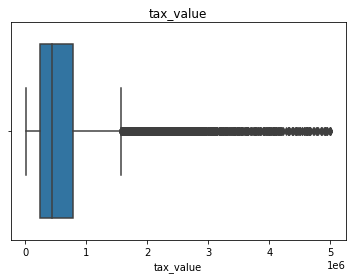

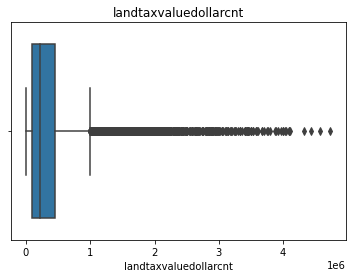

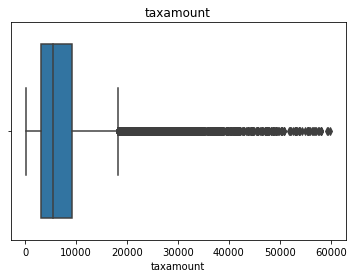

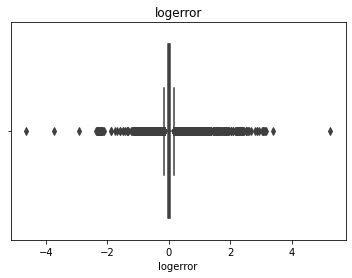

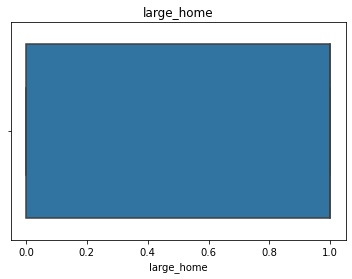

In [49]:
# here are boxplots for all columns with outliers removed
for col in df.columns:
    sns.boxplot(df_out[col])
    plt.title(col)
    plt.show()

In [50]:
df.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'area', 'zipcode', 'latitude',
       'longitude', 'lot_area', 'regionidcity', 'structuretaxvaluedollarcnt',
       'tax_value', 'landtaxvaluedollarcnt', 'taxamount', 'logerror',
       'large_home'],
      dtype='object')

In [51]:
# #defining the columns to remove outliers from
# cols = ['bathrooms', 'bedrooms',
#        'area','lot_area','tax_value',
#        'taxamount']
# k= 3
# # create a df with no outliers 
# df_no_outs =outlier_function(df,cols, k)

In [52]:
#df_no_outs.shape

In [53]:
df.shape

(66515, 15)

In [54]:
# time to split the df in prepartion for exploration
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.train_validate_test(df,'logerror')

In [55]:
train.shape

(37248, 15)

In [56]:
X_train.head()

,parcelid,bathrooms,bedrooms,area,zipcode,latitude,longitude,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,large_home
43359,14340487,4.50,5.00,"4,038.00","6,059.00","33,764,374.00","-117,764,179.00","11,964.00","27,491.00","570,772.00","1,077,836.00","507,064.00","12,439.58",1
28406,14747007,1.00,1.00,726.00,"6,059.00","33,674,123.00","-117,989,675.00","7,313.00","25,218.00","56,722.00","915,407.00","858,685.00","10,302.96",0
63945,11583352,1.00,1.00,865.00,"6,037.00","34,025,700.00","-118,498,000.00","7,513.00","26,964.00","70,101.00","350,537.00","280,436.00","4,388.57",0
12623,14437280,3.00,2.00,"1,903.00","6,059.00","33,445,219.00","-117,627,103.00","12,300.00","13,693.00","237,382.00","641,990.00","404,608.00","6,445.88",0
25088,13095063,2.00,4.00,"1,200.00","6,037.00","34,036,870.00","-117,924,184.00","6,048.00","14,542.00","168,023.00","454,323.00","286,300.00","5,326.98",0


In [57]:
# I am splitting the df_no_outs into train, test, split but with no outliers
train_no_outs, validate_no_outs, test_no_outs, X_train_no_outs, y_train_no_outs, X_validate_no_outs, y_validate_no_outs, X_test_no_outs, y_test_no_outs = prepare.train_validate_test(df_no_outs,df.logerror)

NameError: name 'df_no_outs' is not defined

In [58]:
# # just the regular split of the regular df
# train, validate, test = prepare.train_validate_test(df, 'logerror')

In [59]:
train.head()

,parcelid,bathrooms,bedrooms,area,zipcode,latitude,longitude,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,logerror,large_home
43359,14340487,4.50,5.00,"4,038.00","6,059.00","33,764,374.00","-117,764,179.00","11,964.00","27,491.00","570,772.00","1,077,836.00","507,064.00","12,439.58",-0.01,1
28406,14747007,1.00,1.00,726.00,"6,059.00","33,674,123.00","-117,989,675.00","7,313.00","25,218.00","56,722.00","915,407.00","858,685.00","10,302.96",-0.12,0
63945,11583352,1.00,1.00,865.00,"6,037.00","34,025,700.00","-118,498,000.00","7,513.00","26,964.00","70,101.00","350,537.00","280,436.00","4,388.57",0.03,0
12623,14437280,3.00,2.00,"1,903.00","6,059.00","33,445,219.00","-117,627,103.00","12,300.00","13,693.00","237,382.00","641,990.00","404,608.00","6,445.88",-0.21,0
25088,13095063,2.00,4.00,"1,200.00","6,037.00","34,036,870.00","-117,924,184.00","6,048.00","14,542.00","168,023.00","454,323.00","286,300.00","5,326.98",0.00,0


In [60]:
# now I will create a df that is scaled
_, train_scaled, validate_scaled, test_scaled = wrangle_functions.min_max_scaler(train, validate, test)

In [61]:
train.head()

,parcelid,bathrooms,bedrooms,area,zipcode,latitude,longitude,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,logerror,large_home
43359,14340487,4.50,5.00,"4,038.00","6,059.00","33,764,374.00","-117,764,179.00","11,964.00","27,491.00","570,772.00","1,077,836.00","507,064.00","12,439.58",-0.01,1
28406,14747007,1.00,1.00,726.00,"6,059.00","33,674,123.00","-117,989,675.00","7,313.00","25,218.00","56,722.00","915,407.00","858,685.00","10,302.96",-0.12,0
63945,11583352,1.00,1.00,865.00,"6,037.00","34,025,700.00","-118,498,000.00","7,513.00","26,964.00","70,101.00","350,537.00","280,436.00","4,388.57",0.03,0
12623,14437280,3.00,2.00,"1,903.00","6,059.00","33,445,219.00","-117,627,103.00","12,300.00","13,693.00","237,382.00","641,990.00","404,608.00","6,445.88",-0.21,0
25088,13095063,2.00,4.00,"1,200.00","6,037.00","34,036,870.00","-117,924,184.00","6,048.00","14,542.00","168,023.00","454,323.00","286,300.00","5,326.98",0.00,0


In [62]:
train.shape

(37248, 15)

**************************************************************************************** Prepare Takeaways

In [63]:
############################################################################ EXPLORE

The topics of interest I would like to explore are:

    1. Is there a relationship between home lot_area and logerror?
    2. Is there a difference in logerror between small and large houses?(Viz size against logerror -Stats test      to confirm)
    
   

In [64]:
#train.drop(columns=['regionidcounty'])

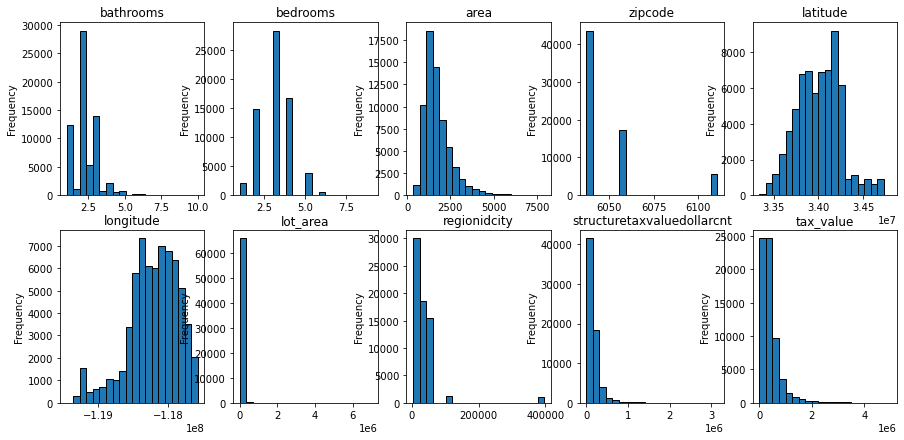

In [65]:
# First let's look at the distribution of each variable
fig, axs = plt.subplots(2, 5, figsize=(15, 7))

for ax, col in zip(axs.flatten(), train.select_dtypes(float)):
    df[col].plot.hist(ax=ax,bins=20, title=col, ec='black')

1. Is there a difference in logerror between small and large houses?(Viz size           against logerror -Stats test to confirm)

Text(0.5, 1.0, 'Features Correlating with Logerror')

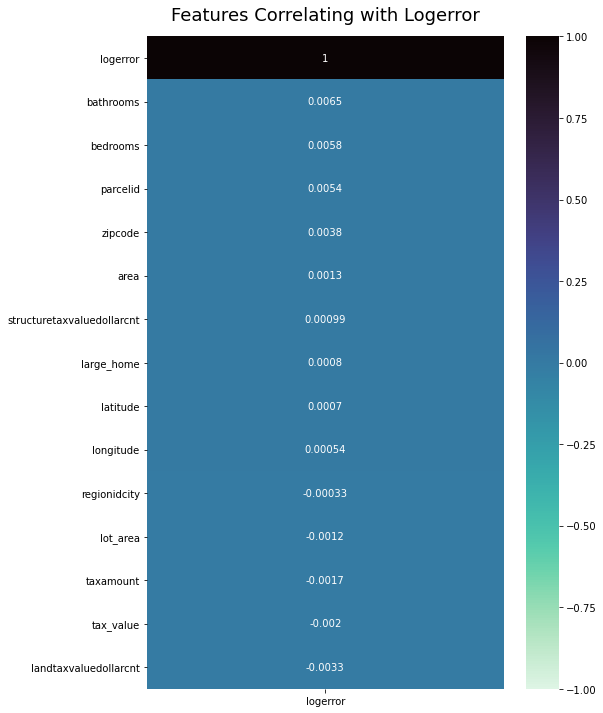

In [66]:
#see what correlates most with logerror with heatmap
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16)

In [67]:
# choosing my features
X = train[['area', 'lot_area']]

In [68]:
# same for the scaled X
X_scaled = train_scaled[['area', 'lot_area']]

array([[<AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'lot_area'}>]], dtype=object)

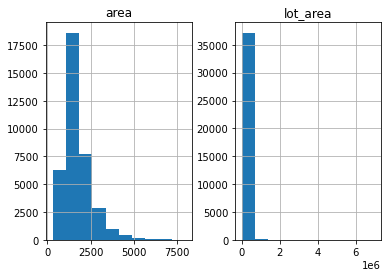

In [69]:
# look at distribution of logerror length and large_home

X.hist()

array([[<AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'lot_area'}>]], dtype=object)

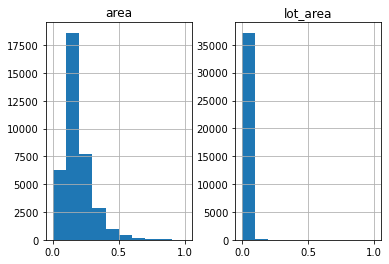

In [70]:
X_scaled.hist()

In [71]:
# sklearn implementation of KMeans

#define it
kmeans_scaled = KMeans(n_clusters=3, random_state=777)

# fit it
kmeans_scaled.fit(X_scaled)

# Use/predict it
kmeans_scaled.predict(X_scaled)

array([0, 1, 1, ..., 2, 1, 2], dtype=int32)

In [72]:
# sklearn implementation of KMeans on unscaled X

#define it
kmeans = KMeans(n_clusters=3, random_state=777)

# fit it
kmeans.fit(X)

# Use/predict it
kmeans.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [73]:
# make a new column names cluster in df and X_scaled dataframe and X dataframe
cluster_features = ['area', 'lot_area']
X['cluster'] = kmeans.predict(X[cluster_features])

X['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

X_scaled['cluster'] = kmeans.predict(X[cluster_features])

X_scaled['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

In [74]:
# taking a peek at the unscaled data
X.head()

,area,lot_area,cluster,scaled_cluster
43359,"4,038.00","11,964.00",0,0
28406,726.00,"7,313.00",0,1
63945,865.00,"7,513.00",0,1
12623,"1,903.00","12,300.00",0,2
25088,"1,200.00","6,048.00",0,1


In [75]:
X_scaled.head()

,area,lot_area,cluster,scaled_cluster
43359,0.49,0.00,0,0
28406,0.05,0.00,0,1
63945,0.07,0.00,0,1
12623,0.21,0.00,0,2
25088,0.12,0.00,0,1


In [76]:
centroids = X.groupby('cluster')['area', 'lot_area'].mean()

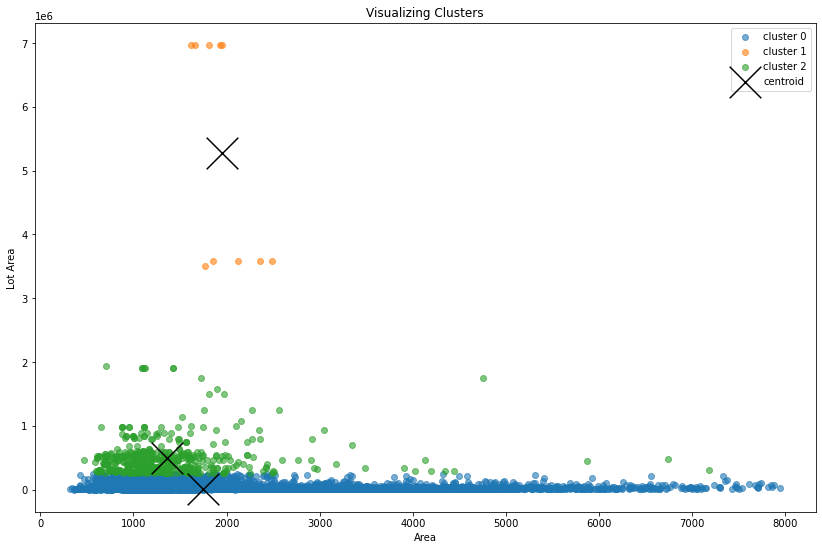

In [77]:
# now I am going to plot the unscaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X.groupby('cluster'):
    plt.scatter(subset.area, subset.lot_area, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='lot_area', x='area', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Area')
plt.ylabel('Lot Area')
plt.title('Visualizing Clusters')
plt.show()

In [78]:
# # One column per home size 
# # One color/shape for each cluster label
# sns.relplot(x="area", y="lot_area", hue="logerror", col="large_home", palette="deep", data=train)

In [79]:
centroids = X_scaled.groupby('scaled_cluster')['area', 'lot_area'].mean()

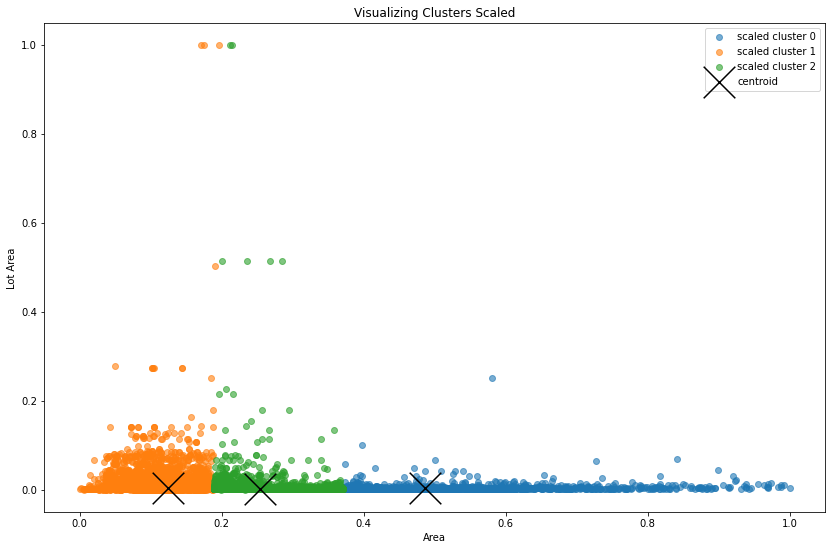

In [80]:
# now I am going to plot the unscaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('scaled_cluster'):
    plt.scatter(subset.area, subset.lot_area, label='scaled cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='lot_area', x='area', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Area')
plt.ylabel('Lot Area')
plt.title('Visualizing Clusters Scaled')
plt.show()

In [81]:
# # getting error here
# # One column per home size 
# # One color/shape for each cluster label
# sns.relplot(x="area", y="lot_area", hue="logerror", col="large_home", palette="deep", data=train_scaled)

In [82]:
train.head()

,parcelid,bathrooms,bedrooms,area,zipcode,latitude,longitude,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,logerror,large_home
43359,14340487,4.50,5.00,"4,038.00","6,059.00","33,764,374.00","-117,764,179.00","11,964.00","27,491.00","570,772.00","1,077,836.00","507,064.00","12,439.58",-0.01,1
28406,14747007,1.00,1.00,726.00,"6,059.00","33,674,123.00","-117,989,675.00","7,313.00","25,218.00","56,722.00","915,407.00","858,685.00","10,302.96",-0.12,0
63945,11583352,1.00,1.00,865.00,"6,037.00","34,025,700.00","-118,498,000.00","7,513.00","26,964.00","70,101.00","350,537.00","280,436.00","4,388.57",0.03,0
12623,14437280,3.00,2.00,"1,903.00","6,059.00","33,445,219.00","-117,627,103.00","12,300.00","13,693.00","237,382.00","641,990.00","404,608.00","6,445.88",-0.21,0
25088,13095063,2.00,4.00,"1,200.00","6,037.00","34,036,870.00","-117,924,184.00","6,048.00","14,542.00","168,023.00","454,323.00","286,300.00","5,326.98",0.00,0


In [83]:
train_scaled.head()

,parcelid,bathrooms,bedrooms,area,zipcode,latitude,longitude,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,logerror,large_home
43359,0.02,0.39,0.50,0.49,0.30,0.29,0.90,0.00,0.06,0.18,0.21,0.11,0.21,0.47,1.00
28406,0.03,0.00,0.00,0.05,0.30,0.23,0.78,0.00,0.06,0.02,0.18,0.18,0.18,0.46,0.00
63945,0.01,0.00,0.00,0.07,0.00,0.47,0.51,0.00,0.06,0.02,0.07,0.06,0.08,0.47,0.00
12623,0.02,0.22,0.12,0.21,0.30,0.07,0.97,0.00,0.03,0.08,0.13,0.09,0.11,0.45,0.00
25088,0.02,0.11,0.38,0.12,0.00,0.48,0.81,0.00,0.03,0.05,0.09,0.06,0.09,0.47,0.00


In [84]:
# building a correlation figure
target = train.logerror
def target_heat(df, target, method='pearson'):
    '''
    Use seaborn to create heatmap with coeffecient annotations to
    visualize correlation between all variables
    '''

    # define variable for corr matrix
    heat_churn = train.corr()[target][:-1]
    # set figure size
    fig, ax = plt.subplots(figsize=(30, 1))
    # define cmap for chosen color palette
    cmap = sns.diverging_palette(h_neg=220, h_pos=13, sep=25, as_cmap=True)
    # plot matrix turned to DataFrame
    sns.heatmap(heat_churn.to_frame().T, cmap=cmap, center=0,
                annot=True, fmt=".1g", cbar=False, square=True)
    #  improve readability of xticks, remove churn ytick
    plt.xticks(ha='right', va='top', rotation=35, rotation_mode='anchor')
    plt.yticks(ticks=[])
    # set title and print graphic
    plt.title(f'Correlation to {target}\n')
    plt.show()


In [85]:
train.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'area', 'zipcode', 'latitude',
       'longitude', 'lot_area', 'regionidcity', 'structuretaxvaluedollarcnt',
       'tax_value', 'landtaxvaluedollarcnt', 'taxamount', 'logerror',
       'large_home'],
      dtype='object')

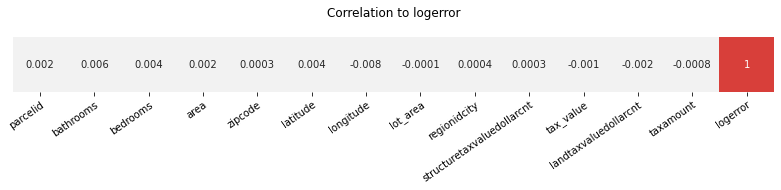

In [86]:
# create heatmap to find any obvious correlations to target
target_heat(train.drop(
    columns=['parcelid','regionidcity','zipcode',
             'tax_value']), 'logerror')

-now I want to perform a pearson r test on logerror and area to check for linear correlation and check the
strength of the correlation
alpha = .05
H0: There is no linear correlation between area and logerror

In [87]:
test_results = stats.pearsonr(train.lot_area, train.logerror)
test_results

(-0.00014890925817242714, 0.9770734402681664)

In [88]:
# the r-value is .0015
# the p-value is very high therefore we must fail to reject the HO and accept that there is not significant correlations
# between lot_area and logerror

In [89]:
# next I will explore my 2nd hypothesis
#Is there a differnce in logerror between area of a home (large_home)?

<AxesSubplot:xlabel='large_home', ylabel='logerror'>

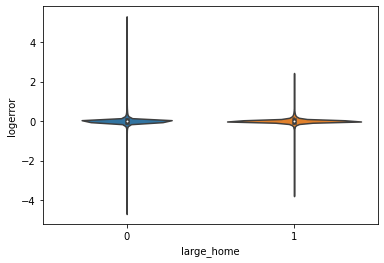

In [90]:
# here is a violinplot to help us answer that question
sns.violinplot(data=train, y='logerror', x='large_home')

**Takeaways**
the violin chart seems to say yes there is more logerror for larger homes

In [91]:
# here is a violinplot to help us answer that question this time with no outliers
sns.violinplot(data=train_no_outs, y='logerror', x='large_home')

NameError: name 'train_no_outs' is not defined

**Takeaways**
without the outliers it looks like there is more logerror in small homes
considering the plot above this with outliers I can't come to any conclusion

Text(0.5, 1.0, 'Is there a difference in logerror for large homes?')

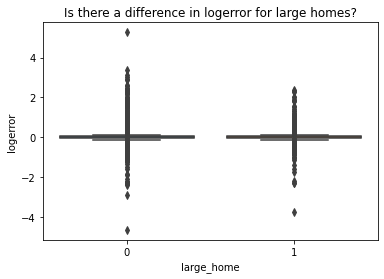

In [92]:
# now let's look at it with a boxplot
sns.boxplot(data=train, y='logerror', x='large_home')
plt.title("Is there a difference in logerror for large homes?")

**Takeaway**
I can't see any significant difference in logerror between the small and large homes

In [93]:
# now let's look at it with a boxplot with no outliers
sns.boxplot(data=train_no_outs, y='logerror', x='large_home')
plt.title("Is there a difference in logerror for large homes?")

NameError: name 'train_no_outs' is not defined

**Takeaway**
I can't see any significant difference in logerror between the small and large homes

<AxesSubplot:xlabel='large_home', ylabel='logerror'>

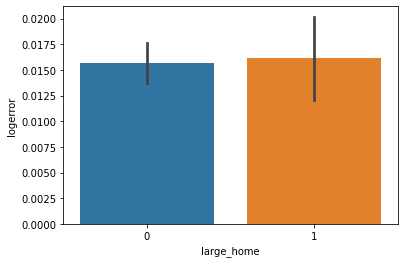

In [94]:
#let's try a barplot to visualize the difference
sns.barplot(data=train, y='logerror', x='large_home')

**Takeaways**
There is higher logerror in large homes

In [95]:
#let's try a barplot to visualize the difference
sns.barplot(data=train_no_outs, y='logerror', x='large_home')

NameError: name 'train_no_outs' is not defined

**Takeaways**
There is slightly higher logerror in large homes even when outliers are romoved

alpha= .05
HO: There is no difference in logerror between large and small homes.
HA: There is a difference in logerror between large and small homes.

In [96]:
# I am going to use a Pearson R test because I will compare two continuous values, logerror and area
test_results = stats.pearsonr(train.area, train.logerror)
test_results

(0.0015182271699964544, 0.7695189062463655)

In [97]:
# the test statistic r at -0.00016509 shows these two are NOT strongly inversely correlated
# the p value is way above the alpha so we fail to reject the HO
# There is no significant difference betweeen logerror in large homes compared to small homes.

In [98]:
# Scale the datasets
scaler = MinMaxScaler()
cols = train.drop(columns=["logerror"]).columns.tolist()

# .copy() makes a copy
# this is an alternative to wrapping the scaled numpy array in a pd.Dataframe()
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()

# apply our scaler (fit only on train!)
train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.transform(validate[cols])
test_scaled[cols] = scaler.transform(test[cols])

In [99]:
train_scaled.head()

,parcelid,bathrooms,bedrooms,area,zipcode,latitude,longitude,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,logerror,large_home
43359,0.02,0.39,0.50,0.49,0.30,0.29,0.90,0.00,0.06,0.18,0.21,0.11,0.21,-0.01,1.00
28406,0.03,0.00,0.00,0.05,0.30,0.23,0.78,0.00,0.06,0.02,0.18,0.18,0.18,-0.12,0.00
63945,0.01,0.00,0.00,0.07,0.00,0.47,0.51,0.00,0.06,0.02,0.07,0.06,0.08,0.03,0.00
12623,0.02,0.22,0.12,0.21,0.30,0.07,0.97,0.00,0.03,0.08,0.13,0.09,0.11,-0.21,0.00
25088,0.02,0.11,0.38,0.12,0.00,0.48,0.81,0.00,0.03,0.05,0.09,0.06,0.09,0.00,0.00


In [100]:
# Fit K-Means 
X = train_scaled[["area", "large_home"]]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

train_scaled['cluster'] = kmeans.predict(X)
train_scaled.head()

,parcelid,bathrooms,bedrooms,area,zipcode,latitude,longitude,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,logerror,large_home,cluster
43359,0.02,0.39,0.50,0.49,0.30,0.29,0.90,0.00,0.06,0.18,0.21,0.11,0.21,-0.01,1.00,2
28406,0.03,0.00,0.00,0.05,0.30,0.23,0.78,0.00,0.06,0.02,0.18,0.18,0.18,-0.12,0.00,0
63945,0.01,0.00,0.00,0.07,0.00,0.47,0.51,0.00,0.06,0.02,0.07,0.06,0.08,0.03,0.00,0
12623,0.02,0.22,0.12,0.21,0.30,0.07,0.97,0.00,0.03,0.08,0.13,0.09,0.11,-0.21,0.00,0
25088,0.02,0.11,0.38,0.12,0.00,0.48,0.81,0.00,0.03,0.05,0.09,0.06,0.09,0.00,0.00,0


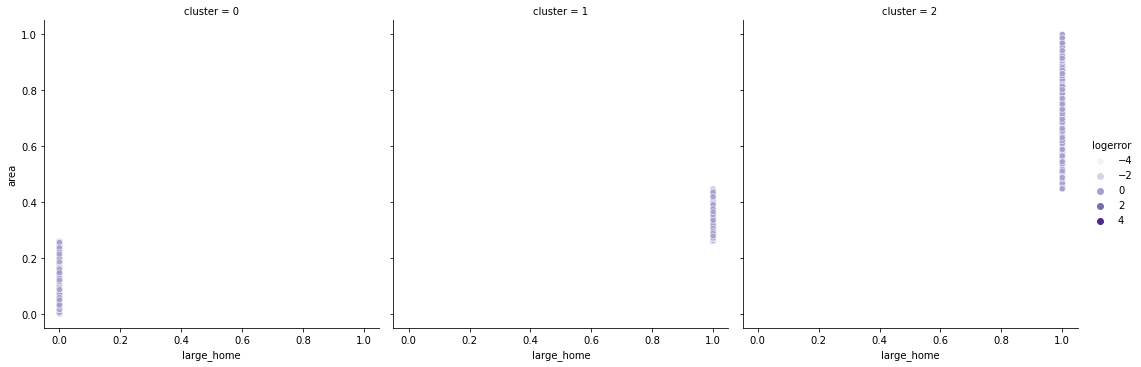

In [101]:
# visualize w/ hue="logerror" style="cluster" with scaled data
sns.relplot(x="large_home", y="area", hue="logerror", col="cluster",palette = 'Purples', data=train_scaled)

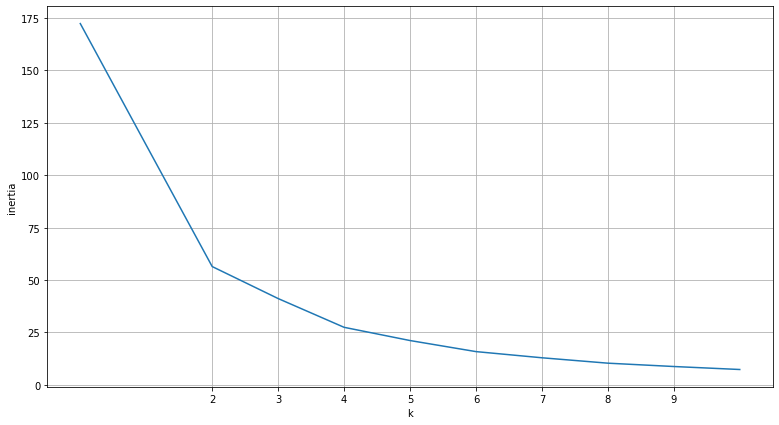

In [102]:
def get_inertia(k):
    return KMeans(k).fit(X).inertia_

plt.figure(figsize=(13, 7))

df = pd.Series([get_inertia(k) for k in range(2, 13)]).plot()

plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(range(2, 10))
plt.grid()

In [103]:
train_scaled.columns

Index(['parcelid', 'bathrooms', 'bedrooms', 'area', 'zipcode', 'latitude',
       'longitude', 'lot_area', 'regionidcity', 'structuretaxvaluedollarcnt',
       'tax_value', 'landtaxvaluedollarcnt', 'taxamount', 'logerror',
       'large_home', 'cluster'],
      dtype='object')

In [104]:
train_scaled.isna().sum()

parcelid                      0
bathrooms                     0
bedrooms                      0
area                          0
zipcode                       0
latitude                      0
longitude                     0
lot_area                      0
regionidcity                  0
structuretaxvaluedollarcnt    0
tax_value                     0
landtaxvaluedollarcnt         0
taxamount                     0
logerror                      0
large_home                    0
cluster                       0
dtype: int64

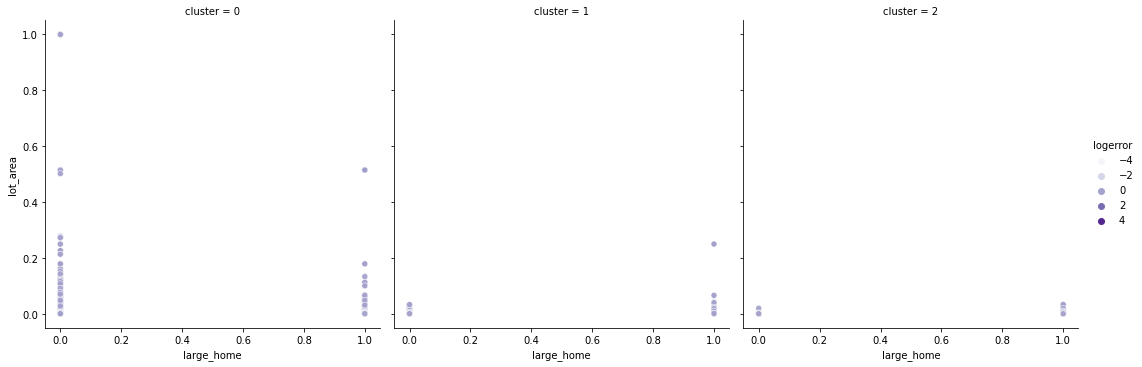

In [105]:
# Fit K-Means
X = train_scaled[['bathrooms', 'bedrooms', 'area', 'zipcode', 'lot_area']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

train_scaled['cluster'] = kmeans.labels_

# visualize w/ hue="logerror" style="cluster"
sns.relplot(x="large_home", y="lot_area", hue="logerror", col="cluster", col_wrap=3,palette = "Purples", data=train_scaled)


In [106]:
######################################## Modeling #######################################

In [107]:
# create kmeans, fit and predict
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

array([2, 2, 0, ..., 0, 0, 2], dtype=int32)

In [108]:
# add this as a column to train
train['cluster'] = kmeans.predict(X)

In [109]:
# distances from the center of each cluster
kmeans.cluster_centers_

array([[ 1.29233390e-01,  2.54355222e-01,  1.77550518e-01,
        -7.85482790e-15,  4.13396031e-03],
       [ 1.47858706e-01,  2.97592998e-01,  2.05916346e-01,
         1.00000000e+00,  1.59103820e-03],
       [ 1.51098680e-01,  2.79356159e-01,  2.03429002e-01,
         2.97266499e-01,  9.86519209e-04]])

In [110]:
# putting them into a df with labels
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,bathrooms,bedrooms,area,zipcode,lot_area
0,0.13,0.25,0.18,-0.00,0.00
1,0.15,0.30,0.21,1.00,0.00
2,0.15,0.28,0.20,0.30,0.00


In [111]:
# plt.figure(figsize=(14, 9))

# for cluster, subset in iris.groupby('cluster'):
#     plt.scatter(subset.area, subset.petal_length, label='cluster ' + str(cluster), alpha=.6)

# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

# plt.legend()
# plt.xlabel('sepal_length')
# plt.ylabel('petal_length')
# plt.title('Visualizing Cluster Centers')

#### move
####### Explore takeaway
❗ Initial Takeaways
Despite being able to reject the null hypotheses, the strength of the correlations are nearly zero for the strongest two negative and two positive relationships. Looking at the regression line on the plots, it looks like an almost flat line. They may have a statistically evident relationship, but the strength of that relationship provides little insight and suggests any individual variable would be unlikely to be a strong driver.

#### move
Exploration of Clusters
In this section, several clusters are created to try and discern potential groupings with significantly difference variances in log_error between those populations. The number of clusters was determined using the elbow plot method to find when change in inertia to $k$ has dropped relative to lower $k$ values. Using analysis of variance (ANOVA) test, those clusters that can reject the respective null hypothesis will be carried into potential model features.

In order to find best performing models, recursive feature elimination (RFE) and SelectKBest were utilized to find recommended features. In this notebook, the best four performing models were brought in to demonstrate to process of creation, and of the twelve models created to finds drivers of log_error, these four all utilized feature engineering functions to select. For additional insight into this and remaining phases, please see the modeling.ipynb notebook.

In [112]:
# Using RFE and SelectKBest to recommend features

In [113]:
X_train.head()

,parcelid,bathrooms,bedrooms,area,zipcode,latitude,longitude,lot_area,regionidcity,structuretaxvaluedollarcnt,tax_value,landtaxvaluedollarcnt,taxamount,large_home
43359,14340487,4.50,5.00,"4,038.00","6,059.00","33,764,374.00","-117,764,179.00","11,964.00","27,491.00","570,772.00","1,077,836.00","507,064.00","12,439.58",1
28406,14747007,1.00,1.00,726.00,"6,059.00","33,674,123.00","-117,989,675.00","7,313.00","25,218.00","56,722.00","915,407.00","858,685.00","10,302.96",0
63945,11583352,1.00,1.00,865.00,"6,037.00","34,025,700.00","-118,498,000.00","7,513.00","26,964.00","70,101.00","350,537.00","280,436.00","4,388.57",0
12623,14437280,3.00,2.00,"1,903.00","6,059.00","33,445,219.00","-117,627,103.00","12,300.00","13,693.00","237,382.00","641,990.00","404,608.00","6,445.88",0
25088,13095063,2.00,4.00,"1,200.00","6,037.00","34,036,870.00","-117,924,184.00","6,048.00","14,542.00","168,023.00","454,323.00","286,300.00","5,326.98",0


In [114]:
# I want to know which are the best features to model on 
model = LinearRegression()

#Initializing RFE model, with parameter to select top 3 features. 
rfe = RFE(model, 3)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)

print(rfe.support_)
print(rfe.ranking_)

[False  True  True False False False False False False False False False
 False  True]
[12  1  1  2  3  7  6 11  8  9  5 10  4  1]


In [115]:
# the above tells me bathrooms, bedrooms, and large_home are the best candidates

In [116]:
# same for the scaled X
X_scaled = train_scaled[['lot_area','bathrooms','bedrooms']]

In [117]:
# let's find the baseline logerror...
train.logerror.mean()

0.015812963327001682

In [135]:
mean = y_train['logerror'].mean()
y_train["logerror_pred_mean"] = mean

rmse_baseline = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean) ** .5

rmse_baseline

0.16907402008616948

In [136]:
X_train.head()

,lot_area,bathrooms,bedrooms
43359,0.00,0.39,0.50
28406,0.00,0.00,0.00
63945,0.00,0.00,0.00
12623,0.00,0.22,0.12
25088,0.00,0.11,0.38


In [137]:
y_train.head()

,logerror,logerror_pred_mean,logerror_pred_median,logerror_pred_lm,logerror_pred_lm2
43359,-0.01,0.02,0.01,0.02,0.02
28406,-0.12,0.02,0.01,0.01,0.01
63945,0.03,0.02,0.01,0.01,0.01
12623,-0.21,0.02,0.01,0.02,0.02
25088,0.00,0.02,0.01,0.02,0.02


In [138]:
X_train.head()

,lot_area,bathrooms,bedrooms
43359,0.00,0.39,0.50
28406,0.00,0.00,0.00
63945,0.00,0.00,0.00
12623,0.00,0.22,0.12
25088,0.00,0.11,0.38


In [139]:
X_train_scaled = train_scaled.drop(columns='logerror')
X_validate_scaled = validate_scaled.drop(columns='logerror')
X_test_scaled = test_scaled.drop(columns='logerror')

In [140]:
X_scaled.head()

,lot_area,bathrooms,bedrooms
43359,0.00,0.39,0.50
28406,0.00,0.00,0.00
63945,0.00,0.00,0.00
12623,0.00,0.22,0.12
25088,0.00,0.11,0.38


In [141]:
# Setting X to the 2 features that were rec. and one from my hypothesis
X_train = X_scaled[['lot_area','bathrooms','bedrooms']]
X_validate = X_validate_scaled[['lot_area','bathrooms','bedrooms']]
X_test = X_test_scaled[['lot_area','bathrooms','bedrooms']]

In [142]:
y_train.head()

,logerror,logerror_pred_mean,logerror_pred_median,logerror_pred_lm,logerror_pred_lm2
43359,-0.01,0.02,0.01,0.02,0.02
28406,-0.12,0.02,0.01,0.01,0.01
63945,0.03,0.02,0.01,0.01,0.01
12623,-0.21,0.02,0.01,0.02,0.02
25088,0.00,0.02,0.01,0.02,0.02


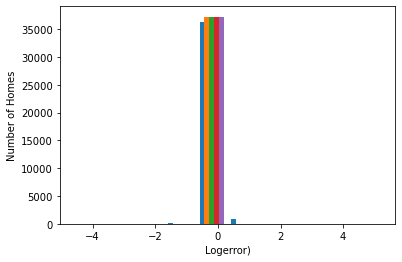

In [143]:
plt.hist(y_train)
plt.xlabel("Logerror)")
plt.ylabel("Number of Homes")
plt.show()

In [144]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict logerror_pred_mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.17
RMSE using Median
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.17


In [154]:
.17 - rmse_baseline

0.0009259799138305325

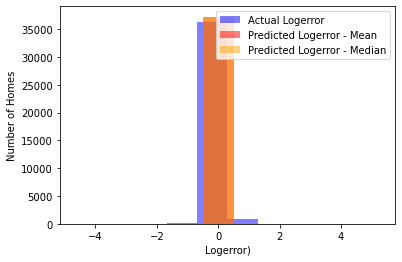

In [145]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.logerror, color='blue', alpha=.5, label="Actual Logerror")
plt.hist(y_train.logerror_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Logerror - Mean")
plt.hist(y_train.logerror_pred_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Logerror - Median")
plt.xlabel("Logerror)")
plt.ylabel("Number of Homes")
plt.legend()
plt.show()

In [146]:
X_train.head

<bound method NDFrame.head of                   lot_area            bathrooms             bedrooms
43359                 0.00                 0.39                 0.50
28406                 0.00                 0.00                 0.00
63945                 0.00                 0.00                 0.00
12623                 0.00                 0.22                 0.12
25088                 0.00                 0.11                 0.38
...                    ...                  ...                  ...
13595                 0.00                 0.33                 0.62
76989                 0.00                 0.00                 0.12
18115                 0.00                 0.22                 0.50
16399                 0.00                 0.11                 0.25
71718                 0.00                 0.22                 0.50

[37248 rows x 3 columns]>

In [147]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16907110561193348 
Validation/Out-of-Sample:  0.17373719448362884


In [148]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [149]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.1690652320333627 
Validation/Out-of-Sample:  0.17373774701583727


In [ ]:
# need to run test on polynomial the best performing model

In [156]:
#trying to compare the baseline rmse to test
print(f'Model outperformed best baseline:\nRMSE difference: {(mean_squared_error(y_test.log_error, y_test.baseline_mean, squared=False) - rmse_test):.4f}\nR^2 difference: \
{(r2_test - explained_variance_score(y_test.log_error, y_test.baseline_mean)):.3f}')

AttributeError: 'Series' object has no attribute 'log_error'

In [150]:
# some values out of range for Tweedie model
# # create the model object
# glm = TweedieRegressor(power=1, alpha=0)

# # fit the model to our training data. We must specify the column in y_train, 
# # since we have converted it to a dataframe from a series! 
# glm.fit(X_train, y_train.logerror)

# # predict train
# y_train['logerror_pred_glm'] = glm.predict(X_train)

# # evaluate: rmse
# rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

# # predict validate
# y_validate['logerror_pred_glm'] = glm.predict(X_validate)

# # evaluate: rmse
# rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

# print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
#       "\nValidation/Out-of-Sample: ", rmse_validate)

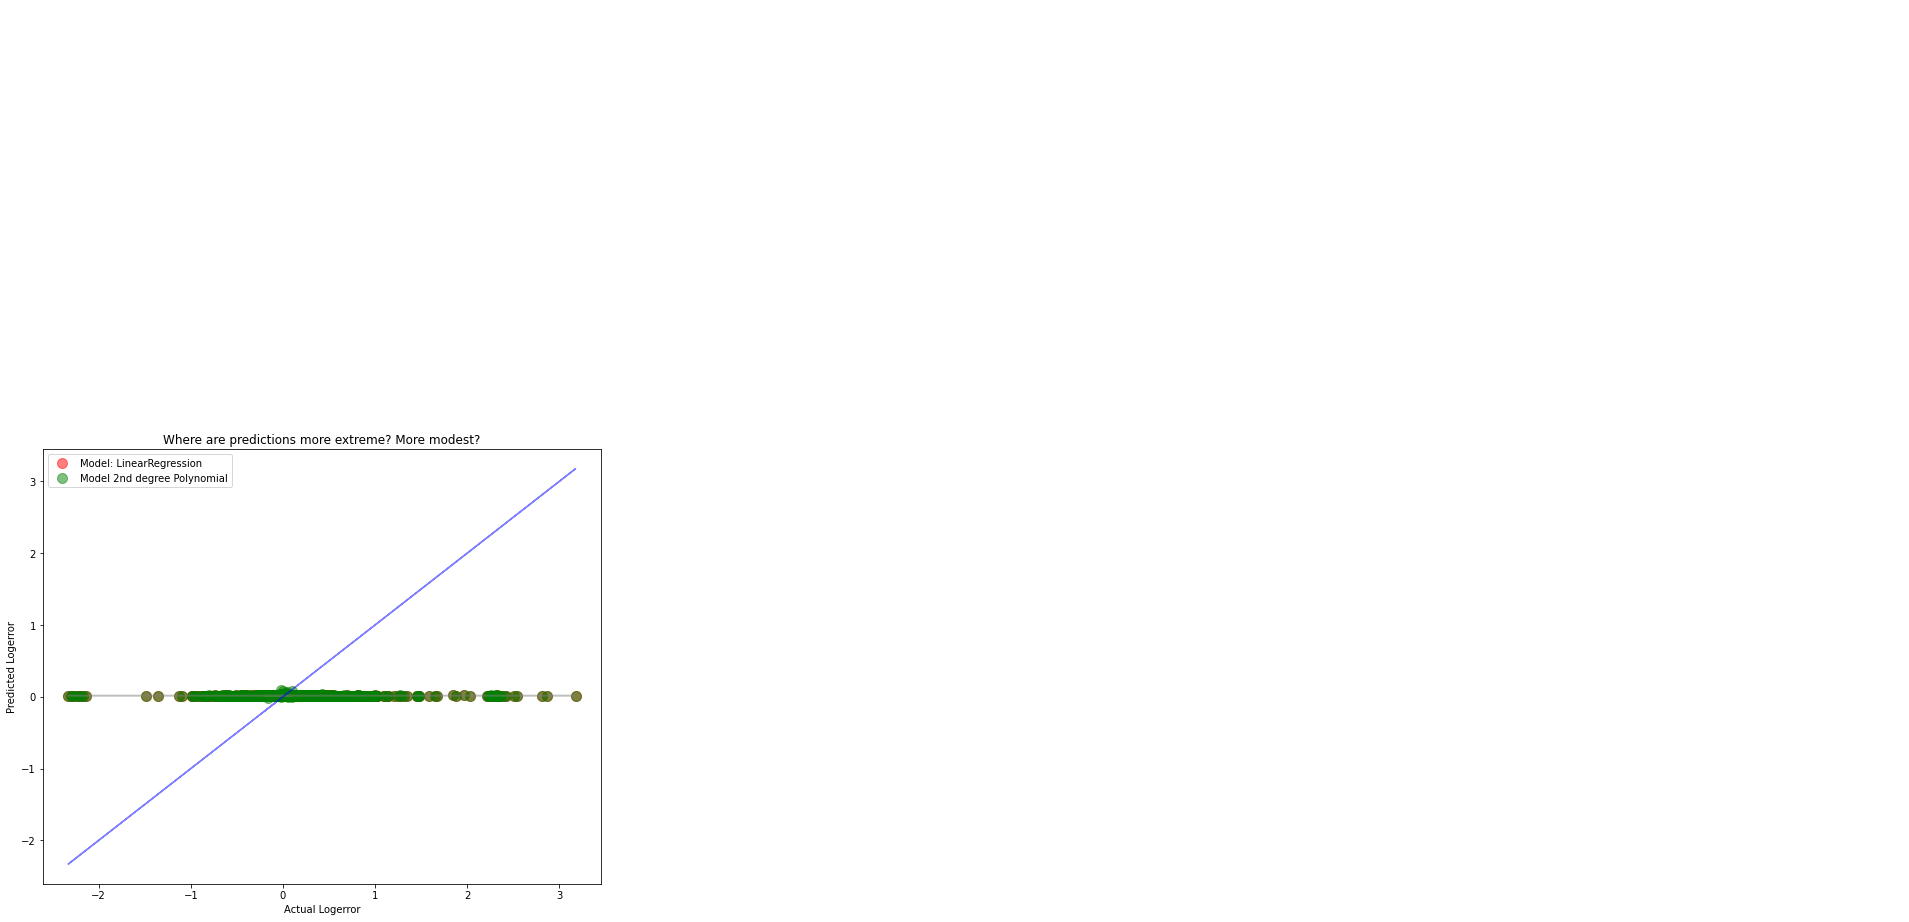

In [151]:
plt.figure(figsize=(10,8))
plt.plot(y_validate.logerror, y_validate.logerror_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.logerror, y_validate.logerror, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
# plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm, 
#             alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Logerror")
plt.ylabel("Predicted Logerror")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

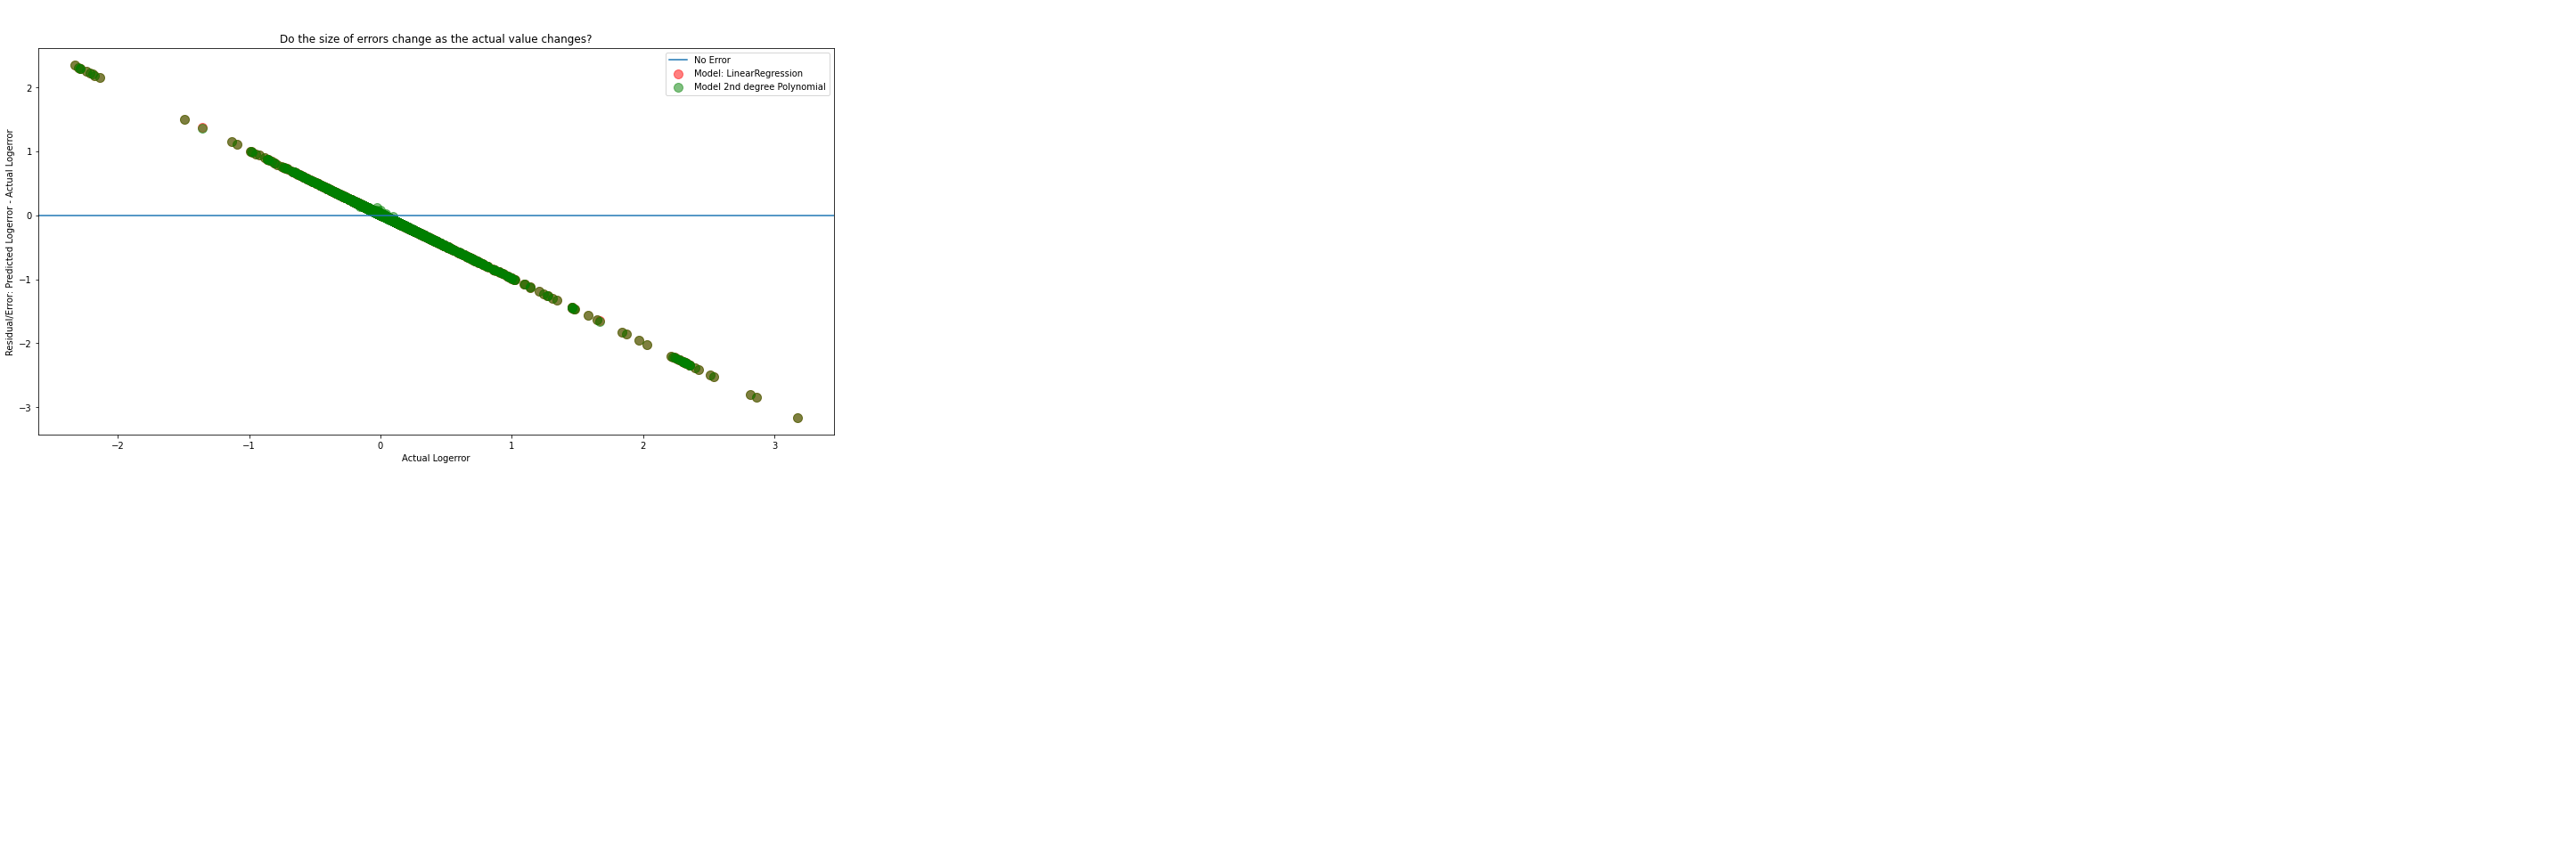

In [152]:
#Residual Plots: Plotting the Errors in Predictions

# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm-y_validate.logerror, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
# plt.scatter(y_validate.G3, y_validate.G3_pred_glm-y_validate.G3, 
#             alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2-y_validate.logerror, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Logerror")
plt.ylabel("Residual/Error: Predicted Logerror - Actual Logerror")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()